In [1]:
import os
import sys
sys.path.append("../bottlenecks")
import configs
from cbm import *
from data_utils import *
from trainer_utils import *
from graph_plot_tools import *
from utils import *
from metric_utils import *
from peft import LoraConfig, get_peft_model
from typing import List, Dict, Optional
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"

2024-03-25 03:04:01.772690: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-25 03:04:01.772810: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-25 03:04:01.772837: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-25 03:04:01.782036: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-25 03:04:02.775467: W tensorflow/compiler/

In [2]:
configs.set_seed(42)
device = configs.set_device(5)

There are 8 GPU(s) available.
We will use the GPU: NVIDIA A100-PCIE-40GB


In [3]:
torch.cuda.get_device_name(device)

'NVIDIA A100-PCIE-40GB'

In [4]:
plt.style.use("seaborn-v0_8")

In [5]:
def accuracy(output, target, topk=(1,)):
    maxk = max(topk)
    batch_size = target.size(0)
    _, pred = output.topk(maxk, 1, True, True)
    pred = pred.t()
    correct = pred.eq(target.view(1, -1).expand_as(pred)).contiguous()
    res = []
    for k in topk:
        correct_k = correct[:k].view(-1).float().sum(0)
        res.append(correct_k.mul_(100.0 / batch_size))
    return res

In [6]:
import evaluate

precision_metric = evaluate.load("precision")
recall_metric = evaluate.load("recall")
f1_metric = evaluate.load("f1")

In [7]:
class LinearProbingModel(torch.nn.Module):
    def __init__(self, 
                 num_classes: int, 
                 backbone_name: str = "openai/clip-vit-base-patch32",
                 train_backbone: bool = False,
     ):
        super().__init__()
        if backbone_name == Constants.altclip_link:
            self.backbone = transformers.AltCLIPModel.from_pretrained(backbone_name)
            self.processor = transformers.AltCLIPProcessor.from_pretrained(
                backbone_name
            )
        elif backbone_name == Constants.align_link:
            self.backbone = transformers.AlignModel.from_pretrained(backbone_name)
            self.processor = transformers.AlignProcessor.from_pretrained(backbone_name)
        elif backbone_name in [
            Constants.siglip_so_link,
            Constants.siglip_base_link,
            Constants.siglip_large_link,
            Constants.siglip_large_256_link,
        ]:
            self.backbone = transformers.AutoModel.from_pretrained(backbone_name)
            self.processor = transformers.AutoProcessor.from_pretrained(backbone_name)
        else:
            self.backbone = transformers.CLIPModel.from_pretrained(backbone_name)
            self.processor = transformers.CLIPProcessor.from_pretrained(backbone_name)
        for param in self.backbone.parameters():
            param.requires_grad = train_backbone
        self.head = torch.nn.Linear(num_classes, num_classes, bias=False)

    def forward(self, **batch):
        logits = self.head(self.backbone(**batch).logits_per_image)
        return logits

#### CUB

In [10]:
with open("../data/cub_classes.txt", "r") as f:
    class_names = f.read().split('\n')

class_names = [c.lower() for c in class_names]

In [12]:
train_loader_preprocessed  = prepared_dataloaders(Constants.cub200_link,
                                                  concepts=class_names,
                                                  prep_loaders="train",
                                                  batch_size=128,
                                                  backbone_name=Constants.clip_large_link,
                                                 )

  0%|          | 0/74 [00:00<?, ?it/s]

In [13]:
val_loader_preprocessed  = prepared_dataloaders(Constants.cub200_link,
                                                  concepts=class_names,
                                                  prep_loaders="val",
                                                  batch_size=128,
                                                  backbone_name=Constants.clip_large_link,
                                                 )

  0%|          | 0/10 [00:00<?, ?it/s]

In [14]:
test_loader_preprocessed  = prepared_dataloaders(Constants.cub200_link,
                                                  concepts=class_names,
                                                  prep_loaders="test",
                                                  batch_size=128,
                                                  backbone_name=Constants.clip_large_link,
                                                 )

  0%|          | 0/10 [00:00<?, ?it/s]

In [25]:
net = LinearProbingModel(
    num_classes=200, 
    backbone_name=Constants.clip_large_link,
    train_backbone=False,
)
criterion = torch.nn.CrossEntropyLoss()

In [26]:
net

LinearProbingModel(
  (backbone): CLIPModel(
    (text_model): CLIPTextTransformer(
      (embeddings): CLIPTextEmbeddings(
        (token_embedding): Embedding(49408, 768)
        (position_embedding): Embedding(77, 768)
      )
      (encoder): CLIPEncoder(
        (layers): ModuleList(
          (0-11): 12 x CLIPEncoderLayer(
            (self_attn): CLIPAttention(
              (k_proj): Linear(in_features=768, out_features=768, bias=True)
              (v_proj): Linear(in_features=768, out_features=768, bias=True)
              (q_proj): Linear(in_features=768, out_features=768, bias=True)
              (out_proj): Linear(in_features=768, out_features=768, bias=True)
            )
            (layer_norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
            (mlp): CLIPMLP(
              (activation_fn): QuickGELUActivation()
              (fc1): Linear(in_features=768, out_features=3072, bias=True)
              (fc2): Linear(in_features=3072, out_features=768, bias

In [27]:
print_trainable_parameters(net)

trainable params: 40,000 || all params: 427,656,513 || trainable%: 0.01


In [38]:
optimizer = torch.optim.Adam(net.head.parameters(), lr=3e-4)
bs_mul = 1
lr_decay = 1

In [44]:
nets = []
nets.append(net)

opts = []
for i in range(1):
    opts += [torch.optim.Adam(net.head.parameters(), lr=3e-4) ]

bs_muls = [1]

In [46]:
hist = []
name = "CLIP-ViT-L/14 Probing, 3e-4"
for (net, optimizer, bs_mul) in zip(nets, opts, bs_muls):
    net.to(device)
    hist.append({
        "run_name": "Probing Experiment",
        "name": name,
        "bs_mul": bs_mul,
        "train_loss": [], "train_x": [],
        "val_loss": [], "val_x": [],
        "train_acc_top_1": [], "train_acc_top_5": [],
        "test_acc_top_1": [], "test_acc_top_5": [],
        "val_acc_top_1": [], "val_acc_top_5": [],
        "val_precision": [], "val_recall": [],
        "val_f1": [], "test_precision": [],
        "test_recall": [], "test_f1": [],
        "norm_diffs": [],
        "epochs_x": [],
        "norm_diffs_x": [],
        "total_steps": 0,
        "prev_val_eval_step": 0,
        "prev_grad_norms_eval_step": 0,
        "batch_end": True
    })

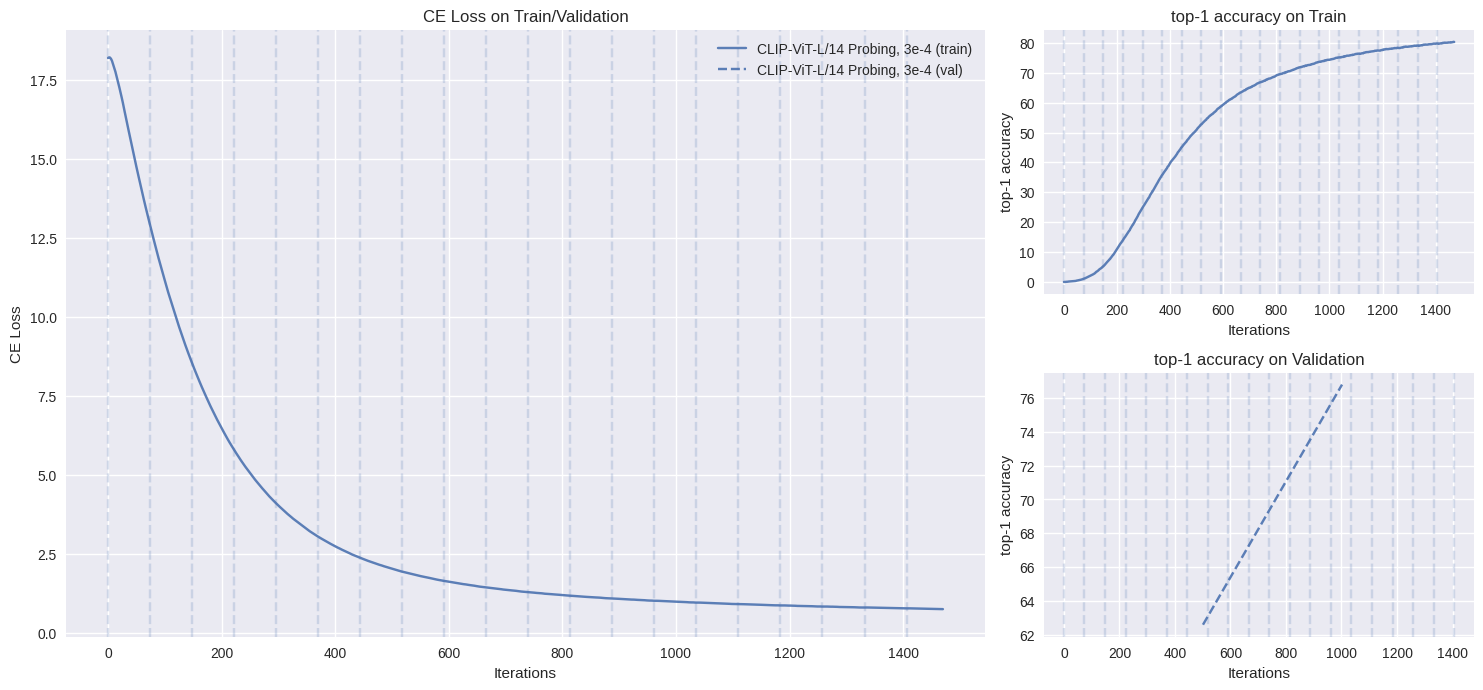

Finished Training


In [48]:
from IPython import display

num_epochs = 10
batch_mul_step_count = 500
norm_diffs_step_count = 500
val_step_count = 500
calc_norm_diffs = False

#loading_path = name
#os.makedirs(loading_path, exist_ok=True)

for epoch in range(num_epochs):
    for (net, optimizer, net_hist) in zip(nets, opts, hist):    
        #net.to(device)
        total_steps = net_hist["total_steps"]
        bs_mul = net_hist["bs_mul"]

        if net_hist["bs_mul"] == "linear":
            if not ("bs_mul_value" in net_hist):
                net_hist["bs_mul_value"] = 1

            bs_mul = net_hist["bs_mul_value"]

        net_hist["epochs_x"].append(total_steps)
        optimizer_head = optimizer

        for i, data in enumerate(train_loader_preprocessed, 0):

            prev_grad_norms_eval_step = net_hist["prev_grad_norms_eval_step"]
            if calc_norm_diffs and ((total_steps - prev_grad_norms_eval_step) > norm_diffs_step_count or
                                    len(net_hist["norm_diffs"]) == 0) and net_hist["batch_end"]:
                net_hist["prev_grad_norms_eval_step"] = total_steps
                net.eval()

                norm_diffs = compute_norm_diffs(
                    net, optimizer_head, None,
                    train_loader_wo_crops, train_loader_wo_crops, repeats=5
                )

                net_hist["norm_diffs"].append(norm_diffs)
                net_hist["norm_diffs_x"].append(total_steps)
                net.train()

            net_hist["batch_end"] = False

            if lr_decay < 1:
                for g in optimizer_head.param_groups:
                    g['lr'] = g['lr'] * lr_decay
            
            inputs, labels = data
            inputs, targets = inputs.to(device), torch.LongTensor(labels).to(device)
            logits = net(**inputs)
            ce_loss = criterion(logits, targets) / bs_mul
            ce_loss.backward()

            if total_steps % bs_mul == bs_mul - 1:
                optimizer_head.step()
                optimizer_head.zero_grad()
                net_hist["batch_end"] = True

            net_hist["train_loss"].append(ce_loss.detach().cpu().item() * bs_mul)
            net_hist["train_x"].append(total_steps)

            if total_steps % bs_mul == bs_mul - 1:
                if net_hist["bs_mul"] == "linear":
                    net_hist["bs_mul_value"] = int(int(total_steps) / batch_mul_step_count) + 1
                    bs_mul = net_hist["bs_mul_value"]

            top_1, top_5 = accuracy(logits, targets, topk=(1, 5))
            net_hist["train_acc_top_1"].append(top_1.detach().cpu().item())
            net_hist["train_acc_top_5"].append(top_5.detach().cpu().item())

            prev_val_eval_step = net_hist["prev_val_eval_step"]
            if (total_steps - prev_val_eval_step) > val_step_count and net_hist["batch_end"]:
                net_hist["prev_val_eval_step"] = total_steps

                net.eval()

                val_cbl_losses = []
                val_ce_losses = []
                val_top_1_accs = []
                val_top_5_accs = []
                val_top_1_precisions = []
                val_top_1_recalls = []
                val_top_1_f1scores = []

                with torch.no_grad():
                    for step, val_data in enumerate(val_loader_preprocessed):

                        inputs, labels = val_data
                        inputs, targets = inputs.to(device), torch.LongTensor(labels).to(device)
                        logits = net(**inputs)
                        
                        top_1, top_5 = accuracy(logits, targets, topk=(1, 5))
                        val_top_1_accs.append(top_1.detach().cpu().item())
                        val_top_5_accs.append(top_5.detach().cpu().item())
                        warnings.filterwarnings('ignore')    
                        precs = precision_metric.compute(predictions=logits.argmax(dim=-1).cpu(), 
                                                            references=targets.cpu(), 
                                                            average='weighted')
                        recs = recall_metric.compute(predictions=logits.argmax(dim=-1).cpu(), 
                                                        references=targets.cpu(), 
                                                        average='weighted')
                        f1 = f1_metric.compute(predictions=logits.argmax(dim=-1).cpu(), 
                                                references=targets.cpu(), 
                                                average='weighted', 
                                                labels=np.unique(logits.argmax(dim=-1).cpu()))
                                                
                        val_top_1_precisions.append(precs['precision'])
                        val_top_1_recalls.append(recs['recall'])
                        val_top_1_f1scores.append(f1['f1'])

                net_hist["val_loss"].append(np.mean(val_ce_losses))

                net_hist["val_acc_top_1"].append(np.mean(val_top_1_accs))
                net_hist["val_acc_top_5"].append(np.mean(val_top_5_accs))
                                                
                net_hist["val_precision"].append(np.mean(val_top_1_precisions))
                net_hist["val_recall"].append(np.mean(val_top_1_recalls))
                net_hist["val_f1"].append(np.mean(val_top_1_f1scores))
                                                
                net_hist["val_x"].append(total_steps)
                net.train()

            if total_steps % 10 == 0:
                display.clear_output(wait=True)

                grouped_hist = group_uniques_full(hist, ["train_loss", "val_loss", "val_acc_top_1", "train_acc_top_1"])

                fig = plt.figure(figsize=(15, 8 + 2 * ((len(grouped_hist) + 2) // 3)))
                gs = GridSpec(4 + 2 * ((len(grouped_hist) + 2) // 3),3, figure=fig)

                ax1 = fig.add_subplot(gs[0:4,:2])
                ax2 = fig.add_subplot(gs[0:2,2])
                ax3 = fig.add_subplot(gs[2:4,2])

                ax1 = make_loss_plot(
                    ax1, grouped_hist, loss_name = "CE Loss", eps=0.01,
                    make_val=True, alpha=0.9) #False
                ax2 = make_accuracy_plot(
                    ax2, grouped_hist, eps=0.01,
                    make_train=True, make_val=False, top_k=1, alpha=0.9)
                ax3 = make_accuracy_plot(
                    ax3, grouped_hist, eps=0.01,
                    make_train=False, make_val=True, top_k=1, alpha=0.9)

                if calc_norm_diffs:
                    draw_norm_hists_for_different_models(fig, gs[4:,:], grouped_hist, bins_n=100, draw_normal=True)

                gs.tight_layout(fig)
                plt.draw()
                plt.show()

            total_steps += 1
        net_hist["total_steps"] = total_steps
        
print('Finished Training')

In [53]:
for (net, optimizer, net_hist) in zip(nets, opts, hist):
            net.eval()
            test_top_1_accs, test_top_5_accs = [], []
            test_top_1_precisions, test_top_1_recalls = [], []
            test_top_1_f1scores = []
            with torch.no_grad():
                for step, batch in tqdm(enumerate(test_loader_preprocessed, 0)):
                    warnings.filterwarnings('ignore')
                    inputs, labels = batch
                    inputs, targets = inputs.to(device), torch.LongTensor(labels).to(device)
                    logits = net(**inputs)
                    top_1, top_5 = accuracy(logits, targets, topk=(1, 5))
                    test_top_1_accs.append(top_1.detach().cpu().item())
                    test_top_5_accs.append(top_5.detach().cpu().item())
                    
                    precs = precision_metric.compute(predictions=logits.argmax(dim=-1).cpu(), 
                                                     references=targets.cpu(), 
                                                     average='weighted')
                    recs = recall_metric.compute(predictions=logits.argmax(dim=-1).cpu(), 
                                                 references=targets.cpu(), 
                                                 average='weighted')
                    f1 = f1_metric.compute(predictions=logits.argmax(dim=-1).cpu(), 
                                           references=targets.cpu(), 
                                           average='weighted', 
                                           labels=np.unique(logits.argmax(dim=-1).cpu()))
                                           
                    test_top_1_precisions.append(precs['precision'])
                    test_top_1_recalls.append(recs['recall'])
                    test_top_1_f1scores.append(f1['f1'])
            
            net_hist["test_acc_top_1"].append(np.mean(test_top_1_accs))
            net_hist["test_acc_top_5"].append(np.mean(test_top_5_accs))
                                           
            net_hist["test_precision"].append(np.mean(test_top_1_precisions))
            net_hist["test_recall"].append(np.mean(test_top_1_recalls))
            net_hist["test_f1"].append(np.mean(test_top_1_f1scores))

0it [00:00, ?it/s]

In [55]:
print("Top 1 Accuracy: ", net_hist["test_acc_top_1"][-1], "\n")
print("Top 5 Accuracy: ", net_hist["test_acc_top_5"][-1], "\n")
print("Top 1 Precision: ",  net_hist["test_precision"][-1], "\n")
print("Top 1 Recall: ",  net_hist["test_recall"][-1], "\n")
print("F1: ", net_hist["test_f1"][-1], "\n")

Top 1 Accuracy:  79.29976806640624 

Top 5 Accuracy:  96.66087951660157 

Top 1 Precision:  0.8113570601851853 

Top 1 Recall:  0.7929976851851852 

F1:  0.9162206139161662 



#### CIFAR10

In [57]:
with open("../data/cifar10_classes.txt", "r") as f:
    class_names = f.read().split('\n')

class_names = [c.lower() for c in class_names]

In [60]:
train_loader_preprocessed  = prepared_dataloaders(Constants.cifar10_link,
                                                  concepts=class_names,
                                                  prep_loaders="train",
                                                  batch_size=128,
                                                  backbone_name=Constants.clip_large_link,
                                                 )

  0%|          | 0/375 [00:00<?, ?it/s]

In [62]:
val_loader_preprocessed  = prepared_dataloaders(Constants.cifar10_link,
                                                  concepts=class_names,
                                                  prep_loaders="val",
                                                  batch_size=128,
                                                  backbone_name=Constants.clip_large_link,
                                                 )

  0%|          | 0/47 [00:00<?, ?it/s]

In [63]:
test_loader_preprocessed  = prepared_dataloaders(Constants.cifar10_link,
                                                  concepts=class_names,
                                                  prep_loaders="test",
                                                  batch_size=128,
                                                  backbone_name=Constants.clip_large_link,
                                                 )

  0%|          | 0/47 [00:00<?, ?it/s]

In [64]:
net = LinearProbingModel(
    num_classes=10, 
    backbone_name=Constants.clip_large_link,
    train_backbone=False,
)
criterion = torch.nn.CrossEntropyLoss()

print_trainable_parameters(net)

trainable params: 100 || all params: 427,616,613 || trainable%: 0.00


In [65]:
optimizer = torch.optim.Adam(net.head.parameters(), lr=3e-4)
bs_mul = 1
lr_decay = 1

nets = []
nets.append(net)
opts = []
for i in range(1):
    opts += [torch.optim.Adam(net.head.parameters(), lr=3e-4) ]
bs_muls = [1]

In [66]:
hist = []
name = "CLIP-ViT-L/14 Probing, 3e-4"
for (net, optimizer, bs_mul) in zip(nets, opts, bs_muls):
    net.to(device)
    hist.append({
        "run_name": "Probing Experiment",
        "name": name,
        "bs_mul": bs_mul,
        "train_loss": [], "train_x": [],
        "val_loss": [], "val_x": [],
        "train_acc_top_1": [], "train_acc_top_5": [],
        "test_acc_top_1": [], "test_acc_top_5": [],
        "val_acc_top_1": [], "val_acc_top_5": [],
        "val_precision": [], "val_recall": [],
        "val_f1": [], "test_precision": [],
        "test_recall": [], "test_f1": [],
        "norm_diffs": [],
        "epochs_x": [],
        "norm_diffs_x": [],
        "total_steps": 0,
        "prev_val_eval_step": 0,
        "prev_grad_norms_eval_step": 0,
        "batch_end": True
    })

In [ ]:
from IPython import display

num_epochs = 10
batch_mul_step_count = 500
norm_diffs_step_count = 500
val_step_count = 500
calc_norm_diffs = False

#loading_path = name
#os.makedirs(loading_path, exist_ok=True)

for epoch in range(num_epochs):
    for (net, optimizer, net_hist) in zip(nets, opts, hist):    
        #net.to(device)
        total_steps = net_hist["total_steps"]
        bs_mul = net_hist["bs_mul"]

        if net_hist["bs_mul"] == "linear":
            if not ("bs_mul_value" in net_hist):
                net_hist["bs_mul_value"] = 1

            bs_mul = net_hist["bs_mul_value"]

        net_hist["epochs_x"].append(total_steps)
        optimizer_head = optimizer

        for i, data in enumerate(train_loader_preprocessed, 0):

            prev_grad_norms_eval_step = net_hist["prev_grad_norms_eval_step"]
            if calc_norm_diffs and ((total_steps - prev_grad_norms_eval_step) > norm_diffs_step_count or
                                    len(net_hist["norm_diffs"]) == 0) and net_hist["batch_end"]:
                net_hist["prev_grad_norms_eval_step"] = total_steps
                net.eval()

                norm_diffs = compute_norm_diffs(
                    net, optimizer_head, None,
                    train_loader_wo_crops, train_loader_wo_crops, repeats=5
                )

                net_hist["norm_diffs"].append(norm_diffs)
                net_hist["norm_diffs_x"].append(total_steps)
                net.train()

            net_hist["batch_end"] = False

            if lr_decay < 1:
                for g in optimizer_head.param_groups:
                    g['lr'] = g['lr'] * lr_decay
            
            inputs, labels = data
            inputs, targets = inputs.to(device), torch.LongTensor(labels).to(device)
            logits = net(**inputs)
            ce_loss = criterion(logits, targets) / bs_mul
            ce_loss.backward()

            if total_steps % bs_mul == bs_mul - 1:
                optimizer_head.step()
                optimizer_head.zero_grad()
                net_hist["batch_end"] = True

            net_hist["train_loss"].append(ce_loss.detach().cpu().item() * bs_mul)
            net_hist["train_x"].append(total_steps)

            if total_steps % bs_mul == bs_mul - 1:
                if net_hist["bs_mul"] == "linear":
                    net_hist["bs_mul_value"] = int(int(total_steps) / batch_mul_step_count) + 1
                    bs_mul = net_hist["bs_mul_value"]

            top_1, top_5 = accuracy(logits, targets, topk=(1, 5))
            net_hist["train_acc_top_1"].append(top_1.detach().cpu().item())
            net_hist["train_acc_top_5"].append(top_5.detach().cpu().item())

            prev_val_eval_step = net_hist["prev_val_eval_step"]
            if (total_steps - prev_val_eval_step) > val_step_count and net_hist["batch_end"]:
                net_hist["prev_val_eval_step"] = total_steps

                net.eval()

                val_cbl_losses = []
                val_ce_losses = []
                val_top_1_accs = []
                val_top_5_accs = []
                val_top_1_precisions = []
                val_top_1_recalls = []
                val_top_1_f1scores = []

                with torch.no_grad():
                    for step, val_data in enumerate(val_loader_preprocessed):

                        inputs, labels = val_data
                        inputs, targets = inputs.to(device), torch.LongTensor(labels).to(device)
                        logits = net(**inputs)
                        
                        top_1, top_5 = accuracy(logits, targets, topk=(1, 5))
                        val_top_1_accs.append(top_1.detach().cpu().item())
                        val_top_5_accs.append(top_5.detach().cpu().item())
                        warnings.filterwarnings('ignore')    
                        precs = precision_metric.compute(predictions=logits.argmax(dim=-1).cpu(), 
                                                            references=targets.cpu(), 
                                                            average='weighted')
                        recs = recall_metric.compute(predictions=logits.argmax(dim=-1).cpu(), 
                                                        references=targets.cpu(), 
                                                        average='weighted')
                        f1 = f1_metric.compute(predictions=logits.argmax(dim=-1).cpu(), 
                                                references=targets.cpu(), 
                                                average='weighted', 
                                                labels=np.unique(logits.argmax(dim=-1).cpu()))
                                                
                        val_top_1_precisions.append(precs['precision'])
                        val_top_1_recalls.append(recs['recall'])
                        val_top_1_f1scores.append(f1['f1'])

                net_hist["val_loss"].append(np.mean(val_ce_losses))

                net_hist["val_acc_top_1"].append(np.mean(val_top_1_accs))
                net_hist["val_acc_top_5"].append(np.mean(val_top_5_accs))
                                                
                net_hist["val_precision"].append(np.mean(val_top_1_precisions))
                net_hist["val_recall"].append(np.mean(val_top_1_recalls))
                net_hist["val_f1"].append(np.mean(val_top_1_f1scores))
                                                
                net_hist["val_x"].append(total_steps)
                net.train()

            if total_steps % 10 == 0:
                display.clear_output(wait=True)

                grouped_hist = group_uniques_full(hist, ["train_loss", "val_loss", "val_acc_top_1", "train_acc_top_1"])

                fig = plt.figure(figsize=(15, 8 + 2 * ((len(grouped_hist) + 2) // 3)))
                gs = GridSpec(4 + 2 * ((len(grouped_hist) + 2) // 3),3, figure=fig)

                ax1 = fig.add_subplot(gs[0:4,:2])
                ax2 = fig.add_subplot(gs[0:2,2])
                ax3 = fig.add_subplot(gs[2:4,2])

                ax1 = make_loss_plot(
                    ax1, grouped_hist, loss_name = "CE Loss", eps=0.01,
                    make_val=True, alpha=0.9) #False
                ax2 = make_accuracy_plot(
                    ax2, grouped_hist, eps=0.01,
                    make_train=True, make_val=False, top_k=1, alpha=0.9)
                ax3 = make_accuracy_plot(
                    ax3, grouped_hist, eps=0.01,
                    make_train=False, make_val=True, top_k=1, alpha=0.9)

                if calc_norm_diffs:
                    draw_norm_hists_for_different_models(fig, gs[4:,:], grouped_hist, bins_n=100, draw_normal=True)

                gs.tight_layout(fig)
                plt.draw()
                plt.show()

            total_steps += 1
        net_hist["total_steps"] = total_steps
        
print('Finished Training')

In [ ]:
for (net, optimizer, net_hist) in zip(nets, opts, hist):
            net.eval()
            test_top_1_accs, test_top_5_accs = [], []
            test_top_1_precisions, test_top_1_recalls = [], []
            test_top_1_f1scores = []
            with torch.no_grad():
                for step, batch in tqdm(enumerate(test_loader_preprocessed, 0)):
                    warnings.filterwarnings('ignore')
                    inputs, labels = batch
                    inputs, targets = inputs.to(device), torch.LongTensor(labels).to(device)
                    logits = net(**inputs)
                    top_1, top_5 = accuracy(logits, targets, topk=(1, 5))
                    test_top_1_accs.append(top_1.detach().cpu().item())
                    test_top_5_accs.append(top_5.detach().cpu().item())
                    
                    precs = precision_metric.compute(predictions=logits.argmax(dim=-1).cpu(), 
                                                     references=targets.cpu(), 
                                                     average='weighted')
                    recs = recall_metric.compute(predictions=logits.argmax(dim=-1).cpu(), 
                                                 references=targets.cpu(), 
                                                 average='weighted')
                    f1 = f1_metric.compute(predictions=logits.argmax(dim=-1).cpu(), 
                                           references=targets.cpu(), 
                                           average='weighted', 
                                           labels=np.unique(logits.argmax(dim=-1).cpu()))
                                           
                    test_top_1_precisions.append(precs['precision'])
                    test_top_1_recalls.append(recs['recall'])
                    test_top_1_f1scores.append(f1['f1'])
            
            net_hist["test_acc_top_1"].append(np.mean(test_top_1_accs))
            net_hist["test_acc_top_5"].append(np.mean(test_top_5_accs))
                                           
            net_hist["test_precision"].append(np.mean(test_top_1_precisions))
            net_hist["test_recall"].append(np.mean(test_top_1_recalls))
            net_hist["test_f1"].append(np.mean(test_top_1_f1scores))

In [1]:
print("Top 1 Accuracy: ", net_hist["test_acc_top_1"][-1], "\n")
print("Top 5 Accuracy: ", net_hist["test_acc_top_5"][-1], "\n")
print("Top 1 Precision: ",  net_hist["test_precision"][-1], "\n")
print("Top 1 Recall: ",  net_hist["test_recall"][-1], "\n")
print("F1: ", net_hist["test_f1"][-1], "\n")

Top 1 Accuracy:  96.12356806647223 

Top 5 Accuracy:  98.79351668971415 

Top 1 Precision:  0.98170601851853 

Top 1 Recall:  0.931456851851852 

F1:  0.9543305140615806 



#### CIFAR100

In [8]:
with open("../data/cifar100_classes.txt", "r") as f:
    class_names = f.read().split('\n')

class_names = [c.lower() for c in class_names]

In [10]:
train_loader_preprocessed  = prepared_dataloaders(Constants.cifar100_link,
                                                  concepts=class_names,
                                                  prep_loaders="train",
                                                  batch_size=128,
                                                  backbone_name=Constants.clip_large_link,
                                                 )

  0%|          | 0/375 [00:00<?, ?it/s]

In [12]:
val_loader_preprocessed  = prepared_dataloaders(Constants.cifar100_link,
                                                  concepts=class_names,
                                                  prep_loaders="val",
                                                  batch_size=128,
                                                  backbone_name=Constants.clip_large_link,
                                                 )

  0%|          | 0/47 [00:00<?, ?it/s]

In [13]:
test_loader_preprocessed  = prepared_dataloaders(Constants.cifar100_link,
                                                  concepts=class_names,
                                                  prep_loaders="test",
                                                  batch_size=128,
                                                  backbone_name=Constants.clip_large_link,
                                                 )

  0%|          | 0/47 [00:00<?, ?it/s]

In [14]:
net = LinearProbingModel(
    num_classes=100, 
    backbone_name=Constants.clip_large_link,
    train_backbone=False,
)
criterion = torch.nn.CrossEntropyLoss()

print_trainable_parameters(net)

trainable params: 10,000 || all params: 427,626,513 || trainable%: 0.00


In [15]:
optimizer = torch.optim.Adam(net.head.parameters(), lr=3e-4)
bs_mul = 1
lr_decay = 1

nets = []
nets.append(net)
opts = []
for i in range(1):
    opts += [torch.optim.Adam(net.head.parameters(), lr=3e-4) ]
bs_muls = [1]

In [16]:
hist = []
name = "CLIP-ViT-L/14 Probing, 3e-4"
for (net, optimizer, bs_mul) in zip(nets, opts, bs_muls):
    net.to(device)
    hist.append({
        "run_name": "Probing Experiment",
        "name": name,
        "bs_mul": bs_mul,
        "train_loss": [], "train_x": [],
        "val_loss": [], "val_x": [],
        "train_acc_top_1": [], "train_acc_top_5": [],
        "test_acc_top_1": [], "test_acc_top_5": [],
        "val_acc_top_1": [], "val_acc_top_5": [],
        "val_precision": [], "val_recall": [],
        "val_f1": [], "test_precision": [],
        "test_recall": [], "test_f1": [],
        "norm_diffs": [],
        "epochs_x": [],
        "norm_diffs_x": [],
        "total_steps": 0,
        "prev_val_eval_step": 0,
        "prev_grad_norms_eval_step": 0,
        "batch_end": True
    })

In [ ]:
from IPython import display

num_epochs = 10
batch_mul_step_count = 500
norm_diffs_step_count = 500
val_step_count = 500
calc_norm_diffs = False

#loading_path = name
#os.makedirs(loading_path, exist_ok=True)

for epoch in range(num_epochs):
    for (net, optimizer, net_hist) in zip(nets, opts, hist):    
        #net.to(device)
        total_steps = net_hist["total_steps"]
        bs_mul = net_hist["bs_mul"]

        if net_hist["bs_mul"] == "linear":
            if not ("bs_mul_value" in net_hist):
                net_hist["bs_mul_value"] = 1

            bs_mul = net_hist["bs_mul_value"]

        net_hist["epochs_x"].append(total_steps)
        optimizer_head = optimizer

        for i, data in enumerate(train_loader_preprocessed, 0):

            prev_grad_norms_eval_step = net_hist["prev_grad_norms_eval_step"]
            if calc_norm_diffs and ((total_steps - prev_grad_norms_eval_step) > norm_diffs_step_count or
                                    len(net_hist["norm_diffs"]) == 0) and net_hist["batch_end"]:
                net_hist["prev_grad_norms_eval_step"] = total_steps
                net.eval()

                norm_diffs = compute_norm_diffs(
                    net, optimizer_head, None,
                    train_loader_wo_crops, train_loader_wo_crops, repeats=5
                )

                net_hist["norm_diffs"].append(norm_diffs)
                net_hist["norm_diffs_x"].append(total_steps)
                net.train()

            net_hist["batch_end"] = False

            if lr_decay < 1:
                for g in optimizer_head.param_groups:
                    g['lr'] = g['lr'] * lr_decay
            
            inputs, labels = data
            inputs, targets = inputs.to(device), torch.LongTensor(labels).to(device)
            logits = net(**inputs)
            ce_loss = criterion(logits, targets) / bs_mul
            ce_loss.backward()

            if total_steps % bs_mul == bs_mul - 1:
                optimizer_head.step()
                optimizer_head.zero_grad()
                net_hist["batch_end"] = True

            net_hist["train_loss"].append(ce_loss.detach().cpu().item() * bs_mul)
            net_hist["train_x"].append(total_steps)

            if total_steps % bs_mul == bs_mul - 1:
                if net_hist["bs_mul"] == "linear":
                    net_hist["bs_mul_value"] = int(int(total_steps) / batch_mul_step_count) + 1
                    bs_mul = net_hist["bs_mul_value"]

            top_1, top_5 = accuracy(logits, targets, topk=(1, 5))
            net_hist["train_acc_top_1"].append(top_1.detach().cpu().item())
            net_hist["train_acc_top_5"].append(top_5.detach().cpu().item())

            prev_val_eval_step = net_hist["prev_val_eval_step"]
            if (total_steps - prev_val_eval_step) > val_step_count and net_hist["batch_end"]:
                net_hist["prev_val_eval_step"] = total_steps

                net.eval()

                val_cbl_losses = []
                val_ce_losses = []
                val_top_1_accs = []
                val_top_5_accs = []
                val_top_1_precisions = []
                val_top_1_recalls = []
                val_top_1_f1scores = []

                with torch.no_grad():
                    for step, val_data in enumerate(val_loader_preprocessed):

                        inputs, labels = val_data
                        inputs, targets = inputs.to(device), torch.LongTensor(labels).to(device)
                        logits = net(**inputs)
                        
                        top_1, top_5 = accuracy(logits, targets, topk=(1, 5))
                        val_top_1_accs.append(top_1.detach().cpu().item())
                        val_top_5_accs.append(top_5.detach().cpu().item())
                        warnings.filterwarnings('ignore')    
                        precs = precision_metric.compute(predictions=logits.argmax(dim=-1).cpu(), 
                                                            references=targets.cpu(), 
                                                            average='weighted')
                        recs = recall_metric.compute(predictions=logits.argmax(dim=-1).cpu(), 
                                                        references=targets.cpu(), 
                                                        average='weighted')
                        f1 = f1_metric.compute(predictions=logits.argmax(dim=-1).cpu(), 
                                                references=targets.cpu(), 
                                                average='weighted', 
                                                labels=np.unique(logits.argmax(dim=-1).cpu()))
                                                
                        val_top_1_precisions.append(precs['precision'])
                        val_top_1_recalls.append(recs['recall'])
                        val_top_1_f1scores.append(f1['f1'])

                net_hist["val_loss"].append(np.mean(val_ce_losses))

                net_hist["val_acc_top_1"].append(np.mean(val_top_1_accs))
                net_hist["val_acc_top_5"].append(np.mean(val_top_5_accs))
                                                
                net_hist["val_precision"].append(np.mean(val_top_1_precisions))
                net_hist["val_recall"].append(np.mean(val_top_1_recalls))
                net_hist["val_f1"].append(np.mean(val_top_1_f1scores))
                                                
                net_hist["val_x"].append(total_steps)
                net.train()

            if total_steps % 10 == 0:
                display.clear_output(wait=True)

                grouped_hist = group_uniques_full(hist, ["train_loss", "val_loss", "val_acc_top_1", "train_acc_top_1"])

                fig = plt.figure(figsize=(15, 8 + 2 * ((len(grouped_hist) + 2) // 3)))
                gs = GridSpec(4 + 2 * ((len(grouped_hist) + 2) // 3),3, figure=fig)

                ax1 = fig.add_subplot(gs[0:4,:2])
                ax2 = fig.add_subplot(gs[0:2,2])
                ax3 = fig.add_subplot(gs[2:4,2])

                ax1 = make_loss_plot(
                    ax1, grouped_hist, loss_name = "CE Loss", eps=0.01,
                    make_val=True, alpha=0.9) #False
                ax2 = make_accuracy_plot(
                    ax2, grouped_hist, eps=0.01,
                    make_train=True, make_val=False, top_k=1, alpha=0.9)
                ax3 = make_accuracy_plot(
                    ax3, grouped_hist, eps=0.01,
                    make_train=False, make_val=True, top_k=1, alpha=0.9)

                if calc_norm_diffs:
                    draw_norm_hists_for_different_models(fig, gs[4:,:], grouped_hist, bins_n=100, draw_normal=True)

                gs.tight_layout(fig)
                plt.draw()
                plt.show()

            total_steps += 1
        net_hist["total_steps"] = total_steps
        
print('Finished Training')

In [ ]:
for (net, optimizer, net_hist) in zip(nets, opts, hist):
            net.eval()
            test_top_1_accs, test_top_5_accs = [], []
            test_top_1_precisions, test_top_1_recalls = [], []
            test_top_1_f1scores = []
            with torch.no_grad():
                for step, batch in tqdm(enumerate(test_loader_preprocessed, 0)):
                    warnings.filterwarnings('ignore')
                    inputs, labels = batch
                    inputs, targets = inputs.to(device), torch.LongTensor(labels).to(device)
                    logits = net(**inputs)
                    top_1, top_5 = accuracy(logits, targets, topk=(1, 5))
                    test_top_1_accs.append(top_1.detach().cpu().item())
                    test_top_5_accs.append(top_5.detach().cpu().item())
                    
                    precs = precision_metric.compute(predictions=logits.argmax(dim=-1).cpu(), 
                                                     references=targets.cpu(), 
                                                     average='weighted')
                    recs = recall_metric.compute(predictions=logits.argmax(dim=-1).cpu(), 
                                                 references=targets.cpu(), 
                                                 average='weighted')
                    f1 = f1_metric.compute(predictions=logits.argmax(dim=-1).cpu(), 
                                           references=targets.cpu(), 
                                           average='weighted', 
                                           labels=np.unique(logits.argmax(dim=-1).cpu()))
                                           
                    test_top_1_precisions.append(precs['precision'])
                    test_top_1_recalls.append(recs['recall'])
                    test_top_1_f1scores.append(f1['f1'])
            
            net_hist["test_acc_top_1"].append(np.mean(test_top_1_accs))
            net_hist["test_acc_top_5"].append(np.mean(test_top_5_accs))
                                           
            net_hist["test_precision"].append(np.mean(test_top_1_precisions))
            net_hist["test_recall"].append(np.mean(test_top_1_recalls))
            net_hist["test_f1"].append(np.mean(test_top_1_f1scores))

In [4]:
print("Top 1 Accuracy: ", net_hist["test_acc_top_1"][-1], "\n")
print("Top 5 Accuracy: ", net_hist["test_acc_top_5"][-1], "\n")
print("Top 1 Precision: ",  net_hist["test_precision"][-1], "\n")
print("Top 1 Recall: ",  net_hist["test_recall"][-1], "\n")
print("F1: ", net_hist["test_f1"][-1], "\n")

Top 1 Accuracy:  80.03711325947329 

Top 5 Accuracy:  95.4953037879092 

Top 1 Precision:  0.81170065811385 

Top 1 Recall:  0.791337582044016 

F1:  0.8606422410780327 

